# Etapa 4 - Criando o modelo


- Essa etapa consiste em carregar a base de dados oriunda dos processos anteriores e criar o modelo XGBoost para previsão de vendas. A discussão mais detalhada dos resultados encontra-se no arquivo Readme do repositório do projeto.

In [62]:
# Importando as bibliotecas
import pandas as pd
import seaborn as sns
# Configurando o matplotlib
%matplotlib inline                              
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate # para executar a validação cruzada
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

In [63]:
# Importando a base de dados
df = pd.read_csv(r'../data/sales_db_03.csv')

In [64]:
#  Transformando a coluna de data para datetime
df['sale_date'] = pd.to_datetime(df['sale_date'])

In [65]:
# Visualizando as informações do dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92197 entries, 0 to 92196
Data columns (total 25 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   sale_date                                     92197 non-null  datetime64[ns]
 1   order_units                                   92197 non-null  int64         
 2   mean_unit_price                               92197 non-null  float64       
 3   state_freq                                    92197 non-null  float64       
 4   product_category_name_automotivo              92197 non-null  float64       
 5   product_category_name_bebes                   92197 non-null  float64       
 6   product_category_name_beleza_saude            92197 non-null  float64       
 7   product_category_name_brinquedos              92197 non-null  float64       
 8   product_category_name_cama_mesa_banho         92197 non-null  floa

In [66]:
# Visualizando a base de dados
df.head(2)

,sale_date,order_units,mean_unit_price,state_freq,product_category_name_automotivo,product_category_name_bebes,product_category_name_beleza_saude,product_category_name_brinquedos,product_category_name_cama_mesa_banho,product_category_name_cool_stuff,...,product_category_name_perfumaria,product_category_name_relogios_presentes,product_category_name_telefonia,product_category_name_utilidades_domesticas,product_category_name_infrequent_sklearn,month,day_of_week,lag_1,lag_7,rolling_mean_7
0,2017-10-02,1,29.99,0.421719,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,10,0,1.0,NaN,NaN
1,2018-07-24,1,118.70,0.033361,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,7,1,1.0,NaN,NaN


In [67]:
# Transformando a data no índice
df.set_index('sale_date', inplace=True)
df = df.sort_index()

In [68]:
# Criando bases de treino e teste
train = df.loc[df.index < '06-01-2018']
test = df.loc[df.index >= '06-01-2018']

# Dividindo as features e target de treino e teste
X_train = train.drop('order_units', axis = 1)
X_test = test.drop('order_units', axis = 1)
y_train = train['order_units']
y_test = test['order_units']

In [69]:
# Criando o modelo
model = xgb.XGBRegressor(
    n_estimators=150,      # Mais árvores
    objective='reg:squarederror',
)

In [70]:
# Parâmetros e partições da validação cruzada
scoring = ['neg_root_mean_squared_error']
num_particoes = 5
kf = KFold(n_splits = num_particoes, shuffle=True, random_state=42)
cv_results = cross_validate(model, X_train, y_train, cv=kf, scoring = scoring)

In [71]:
# Plotando o RMSE da validação cruzada
print('RMSE validação cruzada: {:.2f}'.format(abs(cv_results['test_neg_root_mean_squared_error'].mean())))

RMSE validação cruzada: 0.47


In [72]:
# Treinando o modelo
model.fit(
    X_train,
    y_train, 
)
# Fazer previsões
predictions = model.predict(X_test)

In [73]:
# Transformando as predições em um dataframe
df_pred = pd.DataFrame(predictions, columns=['order_units'])

df_pred['sale_date'] = y_test.index

df_pred = df_pred.groupby('sale_date').sum()

In [74]:
# Avaliando o modelo
mse = mean_squared_error(y_test, predictions)
print(f'MSE por venda prevista: {mse:.2f}')
print(f'RMSE MSE por dia por estado: {np.sqrt(mse):.2f}')

MSE por venda prevista: 0.20
RMSE MSE por dia por estado: 0.45


In [75]:
# Bases para visualização dos resultados
y_train_anl = pd.DataFrame(y_train).groupby('sale_date').sum()
y_test_anl = pd.DataFrame(y_test).groupby('sale_date').sum()

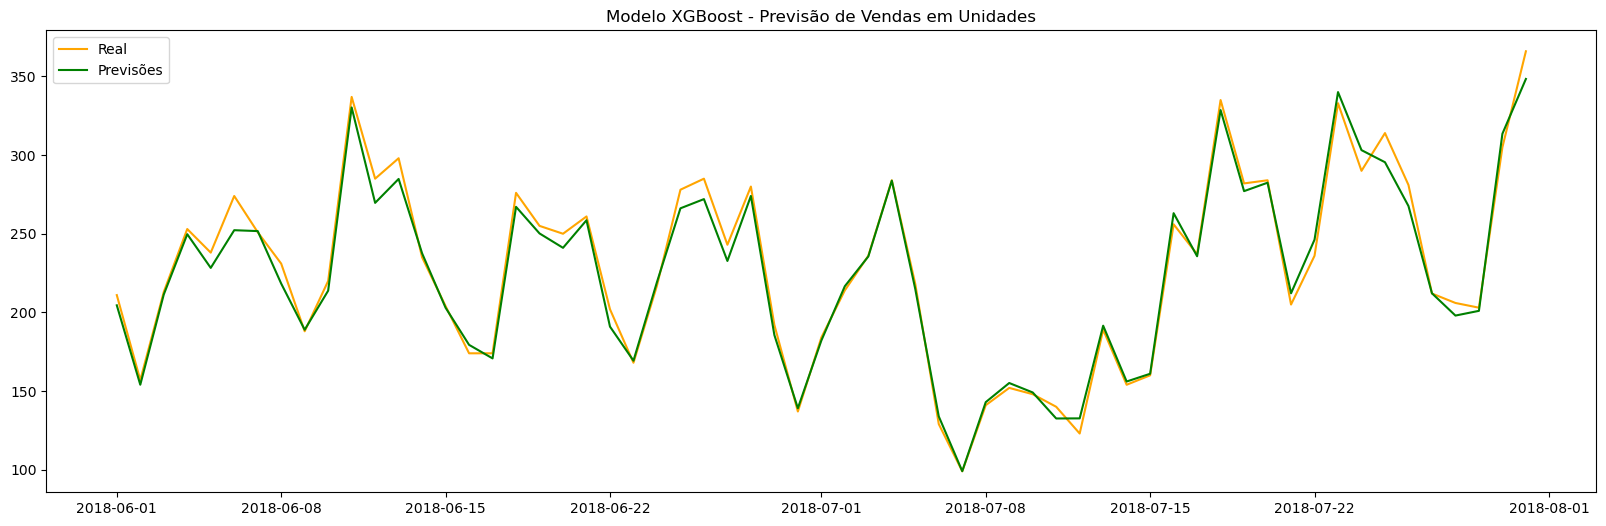

In [76]:
# Plotar resultados
plt.figure(figsize=(20, 6))
#plt.plot(y_train_anl['order_units'], label='Treino')
plt.plot(y_test_anl, label='Real', color='orange')
plt.plot(df_pred, label='Previsões', color='green')
plt.legend()
plt.title('Modelo XGBoost - Previsão de Vendas em Unidades')
plt.show()

In [77]:
# Criando base para gráfico
df_chart2 = pd.DataFrame(y_test.reset_index())
df_chart2['pred'] = predictions


df_chart2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12654 entries, 0 to 12653
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   sale_date    12654 non-null  datetime64[ns]
 1   order_units  12654 non-null  int64         
 2   pred         12654 non-null  float32       
dtypes: datetime64[ns](1), float32(1), int64(1)
memory usage: 247.3 KB


In [78]:
# Criando a coluna de mês
df_chart2['year_month'] = df_chart2['sale_date'].dt.year.astype('str') + ' - ' + df_chart2['sale_date'].dt.month.astype('str')

In [79]:
df_chart2 = df_chart2.drop('sale_date', axis = 1).groupby('year_month').sum()

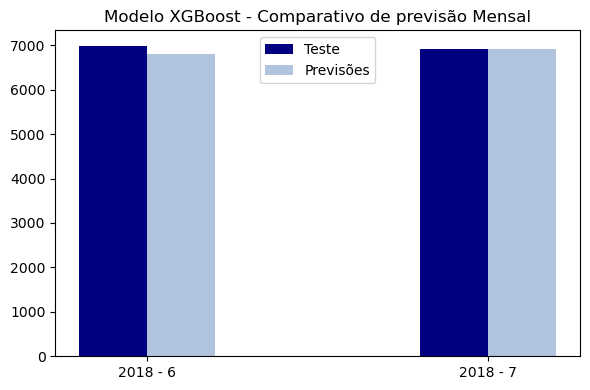

In [80]:
# Configurando gráfico
bar_width = 0.2
categories = df_chart2.index.values
x = np.arange(len(categories))

# Plotar resultados
fig, ax = plt.subplots(figsize=(6,4))
#plt.plot(y_train_anl['order_units'], label='Treino')
ax.bar(x - bar_width / 2, df_chart2['order_units'], width=bar_width, label='Teste', color='navy')
ax.bar(x + bar_width / 2, df_chart2['pred'], width=bar_width, label='Previsões', color='lightsteelblue')

# Configurações do Gráfico
plt.xticks(x, categories)
plt.legend(loc='upper center')
plt.title('Modelo XGBoost - Comparativo de previsão Mensal')
plt.tight_layout()

plt.show()

- Salvando o Modelo:

In [81]:
# Salvando o modelo
import joblib

# Salvando o modelo com joblib
joblib.dump(model, r'../models/model_xgb_01.pkl')

['../models/model_xgb_01.pkl']